In [1]:
from scipy import signal
from scipy.io import wavfile #to read and write wavfiles
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy, scipy, IPython.display as ipd, matplotlib.pyplot as plt
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)


import vamp
import argparse
import os
import numpy as np
from midiutil.MidiFile import MIDIFile
from scipy.signal import medfilt
import jams

#### Load an audio file

In [2]:
def load_audio():
    filename = 'audio/tiersen11.wav'
    x, sr = librosa.load(filename)
    return x, sr

x, sr = load_audio()

#### Record Audio

In [3]:
def record_audio():
    fs = 44100
    data = record(rate=fs, chunk_size=1024, record_seconds=10)
    return fs, data

# x, sr = record_audio()

#### Play the audio file.

In [4]:
ipd.Audio(x, rate=sr)

#### Display the CQT (Constant Q Transform) of the signal.

In [5]:
bins_per_octave = 36
cqt = librosa.cqt(x, sr=sr, n_bins=300, bins_per_octave=bins_per_octave)
log_cqt = librosa.amplitude_to_db(librosa.magphase(cqt)[0])

In [6]:
cqt.shape

(300, 166)

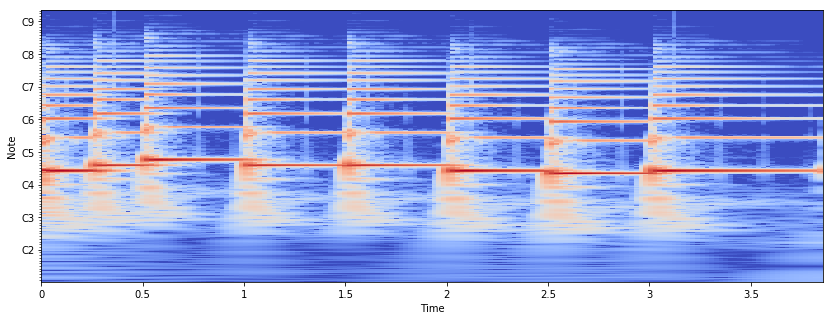

In [7]:
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave)

#### Goal: Identify the pitch of each note and replace each note with a pure tone of that pitch.

## Step 1: Detect Onsets

#### To accurately detect onsets, it may be helpful to see what the novelty funYction looks like:

In [8]:
hop_length = 100
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)

(0, 850)

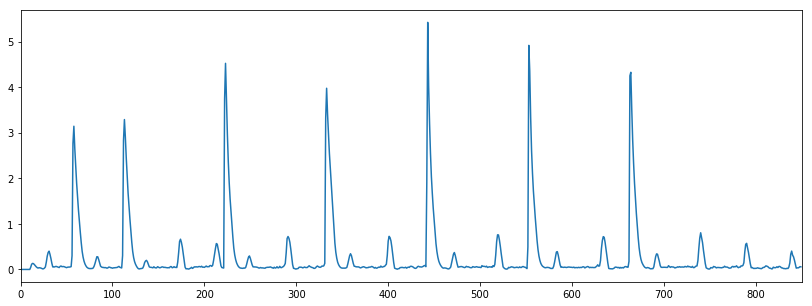

In [9]:
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

#### Among the obvious large peaks, there are many smaller peaks. We want to choose parameters which preserve the large peaks while ignoring the small peaks.  Next, we try to detect onsets.

In [10]:
onset_samples = librosa.onset.onset_detect(x,
                                           sr=sr, units='samples', 
                                           hop_length=hop_length, 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

In [11]:
onset_samples

array([ 5800, 11300, 22300, 33300, 44300, 55300, 66400])

#### Let's pad the onsets with the beginning and end of the signal.

In [12]:
onset_boundaries = numpy.concatenate([[0], onset_samples, [len(x)]])

In [13]:
print onset_boundaries

[    0  5800 11300 22300 33300 44300 55300 66400 84928]


#### Convert the onsets to units of seconds:

In [14]:
onset_times = librosa.samples_to_time(onset_boundaries, sr=sr)
onset_times

array([0.        , 0.26303855, 0.51247166, 1.01133787, 1.51020408,
       2.00907029, 2.50793651, 3.01133787, 3.85160998])

#### Display the results of the onset detection:

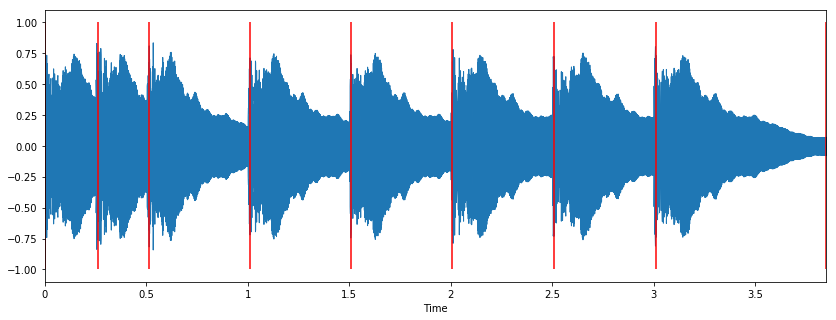

In [15]:
librosa.display.waveplot(x, sr=sr)
plt.vlines(onset_times, -1, 1, color='r')

## Step 2: Estimate Pitch

#### Estimate pitch using the autocorrelation method:

In [16]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

## Step 3: Generate Pure Tone

#### Create a function to generate a pure tone at the specified frequency:

In [17]:
def generate_sine(f0, sr, n_duration):
    n = numpy.arange(n_duration)
    return 0.2*numpy.sin(2*numpy.pi*f0*n/float(sr))

## Step 4: Synthesize and plot synthesized CQT

#### Create a helper function for use in a list comprehension:

In [18]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

#### Use a list comprehension to concatenate the synthesized segments:

In [19]:
y = numpy.concatenate([
    estimate_pitch_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

#### Play the synthesized transcription.

In [20]:
ipd.Audio(y, rate=sr)

#### Plot the CQT of the synthesized transcription.

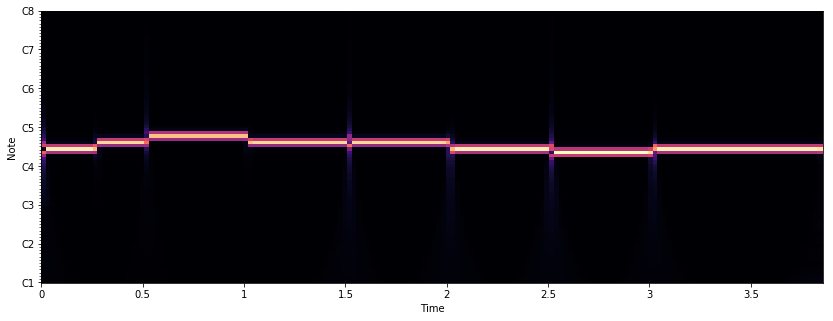

In [21]:
cqt = librosa.cqt(y, sr=sr)
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')

#### Now convert the synthesized y audio to midi with the help of "audio to melodia file". then convert that midi to sheet music.

#### write synthesized signal

In [22]:
# pip install vamp
# pip install MIDIUtil
# pip install --user jams



In [23]:
def save_jams(jamsfile, notes, track_duration, orig_filename):

    # Construct a new JAMS object and annotation records
    jam = jams.JAMS()

    # Store the track duration
    jam.file_metadata.duration = track_duration
    jam.file_metadata.title = orig_filename

    midi_an = jams.Annotation(namespace='pitch_midi',
                              duration=track_duration)
    midi_an.annotation_metadata = \
        jams.AnnotationMetadata(
            data_source='audio_to_midi_melodia.py v%s' % __init__.__version__,
            annotation_tools='audio_to_midi_melodia.py (https://github.com/'
                             'justinsalamon/audio_to_midi_melodia)')

    # Add midi notes to the annotation record.
    for n in notes:
        midi_an.append(time=n[0], duration=n[1], value=n[2], confidence=0)

    # Store the new annotation in the jam
    jam.annotations.append(midi_an)

    # Save to disk
    jam.save(jamsfile)


def save_midi(outfile, notes, tempo):

    track = 0
    time = 0
    midifile = MIDIFile(1)

    # Add track name and tempo.
    midifile.addTrackName(track, time, "MIDI TRACK")
    midifile.addTempo(track, time, tempo)

    channel = 0
    volume = 100

    for note in notes:
        onset = note[0] * (tempo/60.)
        duration = note[1] * (tempo/60.)
        # duration = 1
        pitch = note[2]
        midifile.addNote(track, channel, pitch, onset, duration, volume)

    # And write it to disk.
    binfile = open(outfile, 'wb')
    midifile.writeFile(binfile)
    binfile.close()


def midi_to_notes(midi, fs, hop, smooth, minduration):

    # smooth midi pitch sequence first
    if (smooth > 0):
        filter_duration = smooth  # in seconds
        filter_size = int(filter_duration * fs / float(hop))
        if filter_size % 2 == 0:
            filter_size += 1
        midi_filt = medfilt(midi, filter_size)
    else:
        midi_filt = midi
    # print(len(midi),len(midi_filt))

    notes = []
    p_prev = None
    duration = 0
    onset = 0
    for n, p in enumerate(midi_filt):
        if p == p_prev:
            duration += 1
        else:
            # treat 0 as silence
            if p_prev > 0:
                # add note
                duration_sec = duration * hop / float(fs)
                # only add notes that are long enough
                if duration_sec >= minduration:
                    onset_sec = onset * hop / float(fs)
                    notes.append((onset_sec, duration_sec, p_prev))

            # start new note
            onset = n
            duration = 1
            p_prev = p

    # add last note
    if p_prev > 0:
        # add note
        duration_sec = duration * hop / float(fs)
        onset_sec = onset * hop / float(fs)
        notes.append((onset_sec, duration_sec, p_prev))

    return notes


def hz2midi(hz):

    # convert from Hz to midi note
    hz_nonneg = hz.copy()
    idx = hz_nonneg <= 0
    hz_nonneg[idx] = 1
    midi = 69 + 12*np.log2(hz_nonneg/440.)
    midi[idx] = 0

    # round
    midi = np.round(midi)

    return midi


def audio_to_midi_melodia(y, sr, hop, outfile, bpm=60, smooth=0.25, minduration=0.1,
                          savejams=False):

    # define analysis parameters
    fs = sr
    hop = hop
    data = y

    

    # extract melody using melodia vamp plugin
    print("Extracting melody f0 with MELODIA...")
    melody = vamp.collect(data, sr, "mtg-melodia:melodia",
                          parameters={"voicing": 0.2})

    # hop = melody['vector'][0]
    pitch = melody['vector'][1]

    # impute missing 0's to compensate for starting timestamp
    pitch = np.insert(pitch, 0, [0]*8)

    # debug
    # np.asarray(pitch).dump('f0.npy')
    # print(len(pitch))

    # convert f0 to midi notes
    print("Converting Hz to MIDI notes...")
    midi_pitch = hz2midi(pitch)

    # segment sequence into individual midi notes
    notes = midi_to_notes(midi_pitch, fs, hop, smooth, minduration)

    # save note sequence to a midi file
    print("Saving MIDI to disk...")
    save_midi(outfile, notes, bpm)

    if savejams:
        print("Saving JAMS to disk...")
        jamsfile = outfile.replace(".mid", ".jams")
        track_duration = len(data) / float(fs)
        save_jams(jamsfile, notes, track_duration, os.path.basename(infile))

    print("Conversion complete.")

In [24]:
#audio_to_midi_melodia(y, sr, hop, outfile, bpm, smooth=0.25, minduration=0.1, savejams=False)
audio_to_midi_melodia(y,sr, hop_length, "/home/ashan/Desktop/test_midi.mid")

Extracting melody f0 with MELODIA...
Converting Hz to MIDI notes...
Saving MIDI to disk...
Conversion complete.
